In [3]:
import numpy as np
import pandas as pd

import plotly.express as px
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.stattools as tsa


from pmdarima.arima import auto_arima, ndiffs, nsdiffs, ADFTest
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import mean_absolute_error, mean_squared_error


In [37]:
#from work.funciones import *

In [10]:
# df_main = pd.read_excel(engine="python","https://github.com/carrenogf/MCD-Series-Temporales/blob/64d7bd2271190301ac5419698736fec4ff37b342/dataset/series_diarias.xlsx")
df_main = pd.read_excel("https://raw.githubusercontent.com/carrenogf/MCD-Series-Temporales/main/dataset/series_diarias.xlsx")
df_main = df_main.sort_values("FECHA",ascending=True)
df_main.set_index("FECHA", inplace=True)
df_copa = df_main["CHU_COPA_AJUST"].dropna()
df_recprop = df_main["CHU_REC_PROPIOS_AJUST"].dropna()
df_regal = df_main["CHU_REGALIAS_AJUST"].dropna()

In [24]:
df_copa.head()


FECHA
2018-01-02    1.231307e+06
2018-01-03    2.875741e+06
2018-01-04    3.933965e+05
2018-01-05    7.066760e+05
2018-01-08    8.765211e+05
Name: CHU_COPA_AJUST, dtype: float64

In [25]:
df_recprop.head()

FECHA
2016-04-01     679233
2016-04-04     339379
2016-04-05     903634
2016-04-06     858197
2016-04-07    1774956
Name: CHU_REC_PROPIOS_AJUST, dtype: int64

In [13]:
df_regal.head()

FECHA
2016-04-08      212159.0
2016-04-14       26246.0
2016-04-15    16002725.0
2016-04-20        5582.0
2016-04-29    11066374.0
Name: CHU_REGALIAS_AJUST, dtype: float64

<h2>Ejercicio 1</h2>
Buscar 3 (tres) series de tiempo y exponer la problemática de interés analítico (es importante detallar cuáles fueron los motivos de elección y situar al lector en el contexto adecuado).

<h2>Ejercicio 2</h2>
Graficar las series originales. Analizar si es necesario diferenciarlas para convertirlas en estacionarias.

Exponer los conceptos relacionados con la estacionariedad de la serie.

In [14]:

def graficar(serie, titulo="", xlabel="Tiempo", ylabel="Tasa", ax=None):
    """Grafica una serie en un eje específico."""
    serie.plot(ax=ax)  # Graficar la serie en el subplot dado

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(titulo)
    ax.legend(loc='best')
    ax.grid(True, color='0.6', dashes=(5, 2, 1, 2))



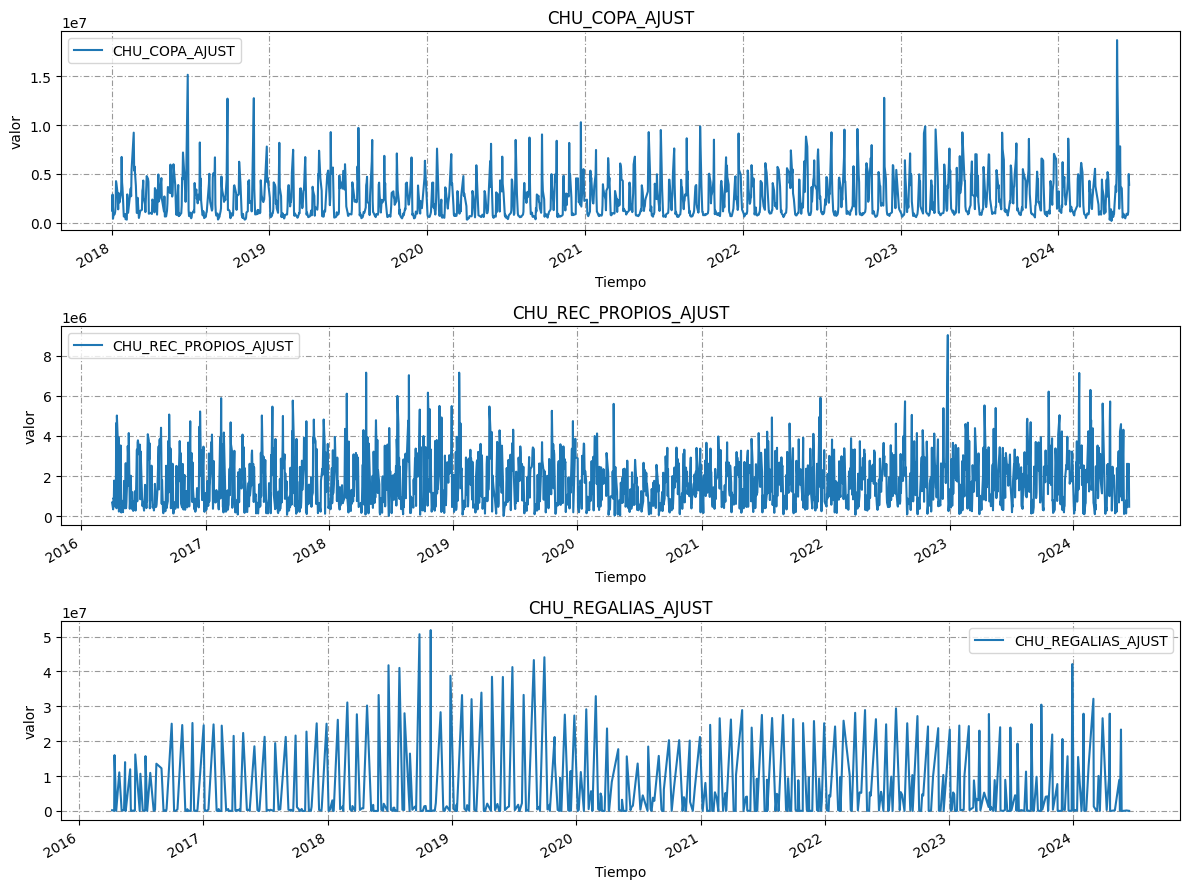

In [63]:
dataframes = [df_copa, df_recprop, df_regal]  # Asegúrate de definir estos dataframes

fig, axes = plt.subplots(3, 1, figsize=(12, 9), dpi=100)  # 3 filas, 1 columna

for i, (df, ax) in enumerate(zip(dataframes, axes)):
    graficar(serie=df,
             titulo=f"{df.name}",
             xlabel="Tiempo",
             ylabel="valor",
             ax=ax)

plt.tight_layout()  # Evitar superposición
plt.show()

In [19]:
# Esta función descompone la serie en sus partes para ver estacionalidad, tendencia, residuos
def componentes(timeserie, periodo):
  decomposition = seasonal_decompose(timeserie, model='additive', period=periodo)
  fig = plt.figure()
  fig = decomposition.plot()
  fig.set_size_inches(15, 8)

<Figure size 640x480 with 0 Axes>

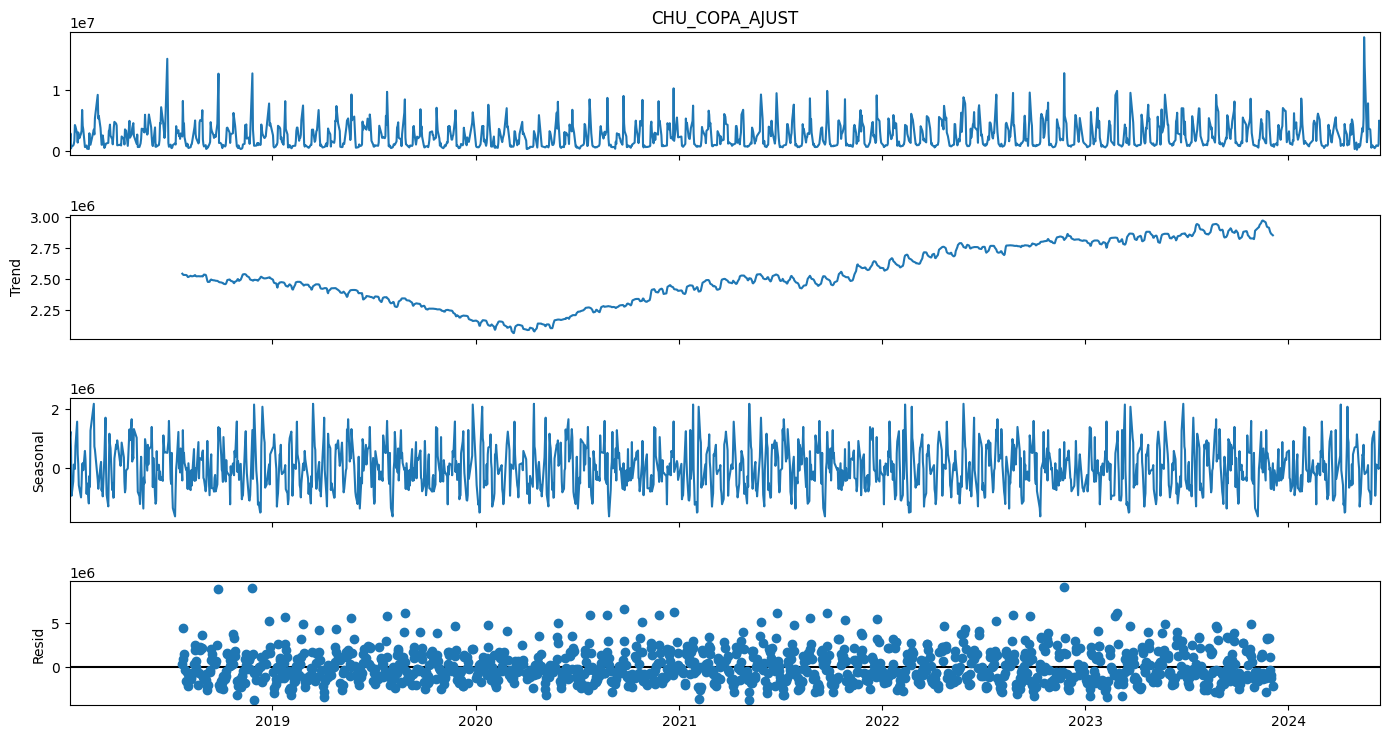

<Figure size 640x480 with 0 Axes>

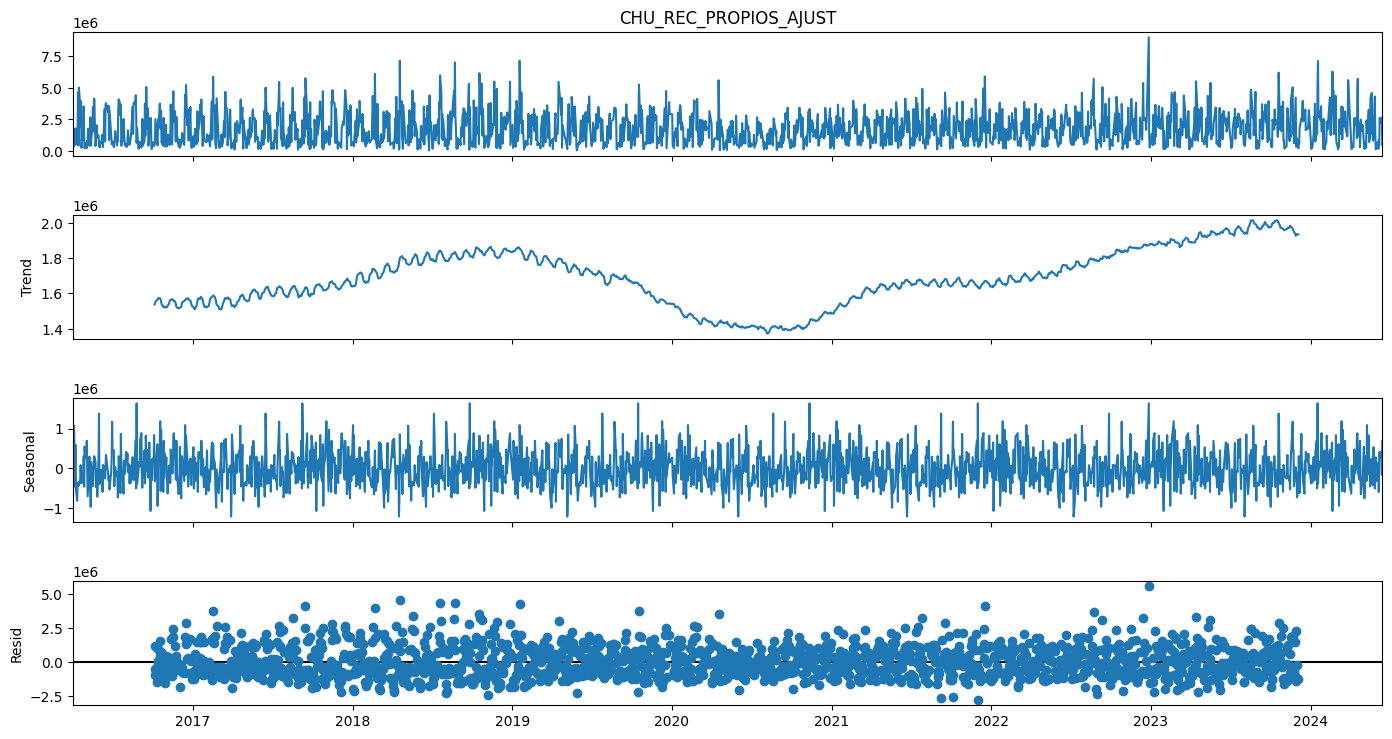

<Figure size 640x480 with 0 Axes>

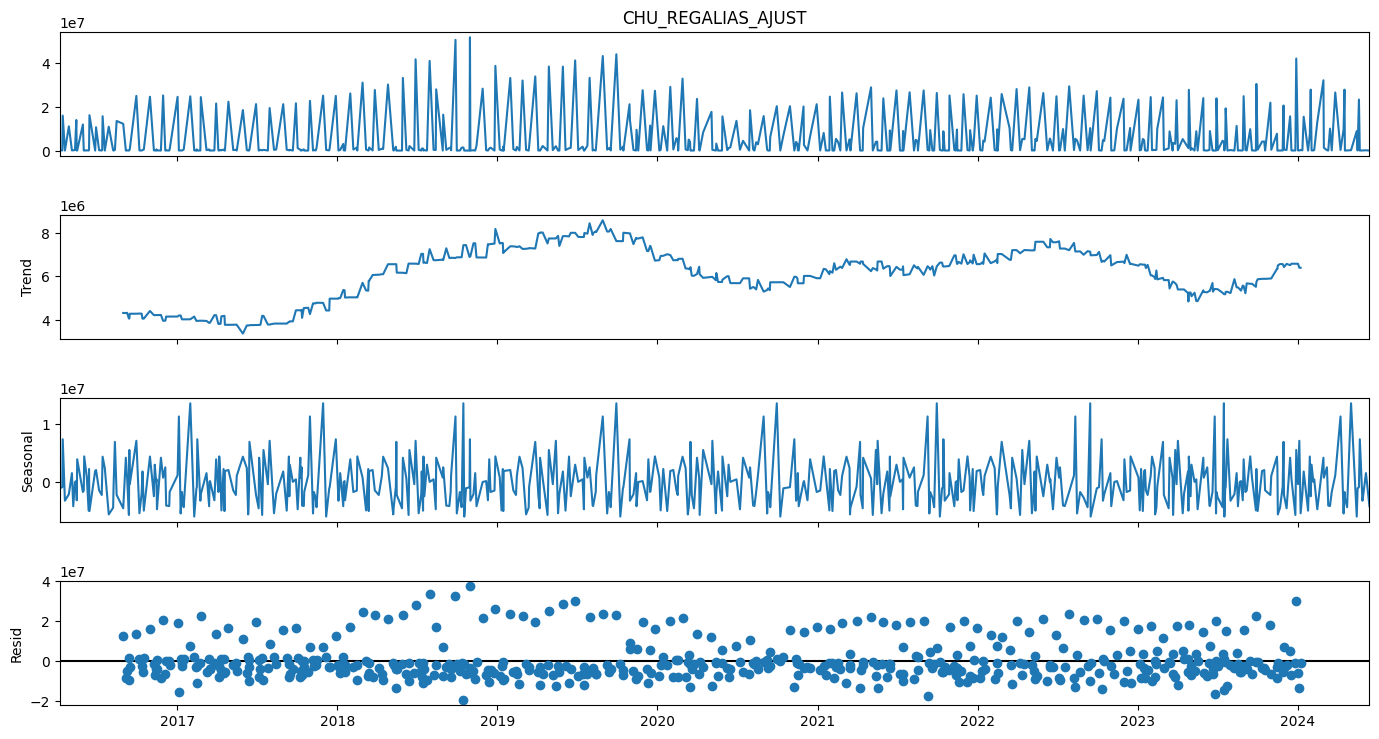

In [23]:
componentes(dataframes[0], 252)
componentes(dataframes[1], 252)
componentes(dataframes[2], 61)

<h2>Ejercicio 3</h2>
Graficar la FAS, FAC y FACP de las mismas en un solo gráfico y analizarlas. ¿Qué puede inferir de los gráficos?.

Justificar con teoría.

In [26]:
## Función para dibujar juntos FAS: autocovarianzas; FAC y FACP, autocorrelación y autocorrelación parcial
def autocov_autocorr(serie_r, nrol=75,serie_titulo=""):
    fig, axes = plt.subplots(3, 1, figsize=(18, 10))

    plot_acf(serie_r, lags=nrol, ax=axes[0], color='blue', vlines_kwargs={"colors": 'blue'})
    axes[0].set_title(f'ACF (Autocorrelación) {serie_titulo}', fontsize=14)

    plot_pacf(serie_r, lags=nrol, ax=axes[1], color='green', vlines_kwargs={"colors": 'green'}, method='ywm')
    axes[1].set_title(f'PACF (Autocorrelación Parcial) {serie_titulo}', fontsize=14)

    axes[2].plot(tsa.acovf(serie_r, fft=False, nlag=nrol), color='red', label='AutoCov')
    axes[2].set_title(f'Autocovarianza {serie_titulo}', fontsize=14)
    axes[2].set_xlabel('Lag')

    plt.tight_layout()
    plt.show()

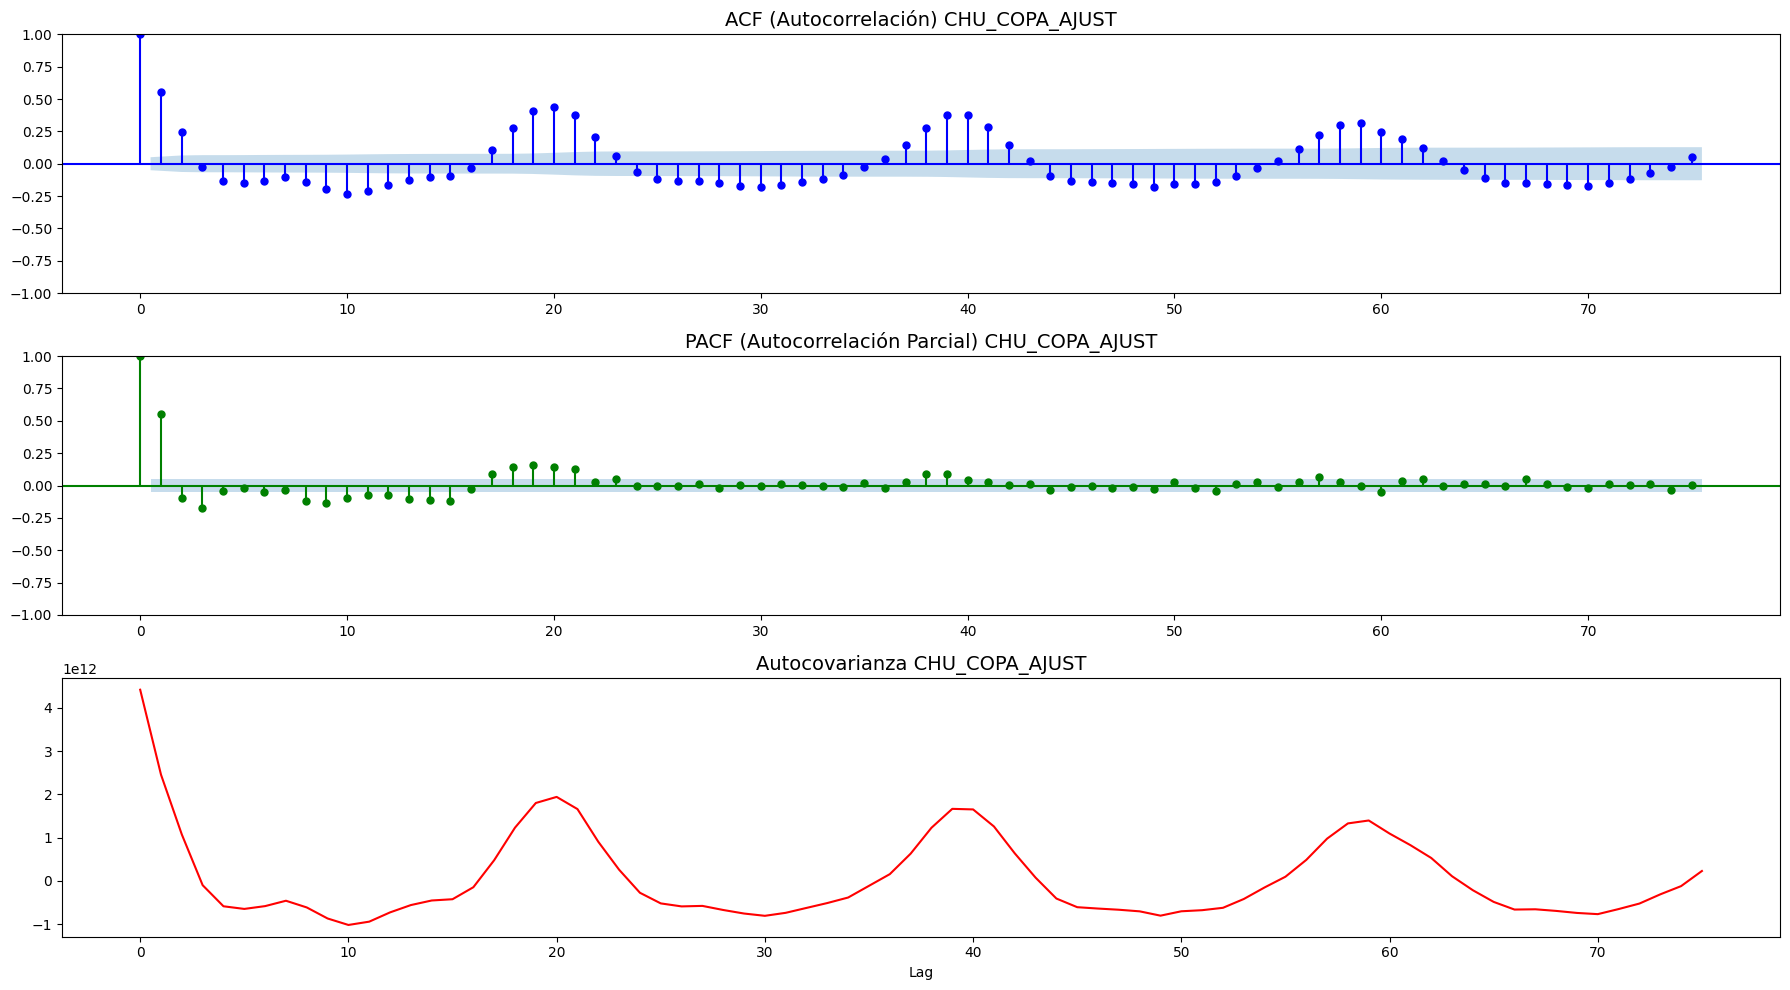

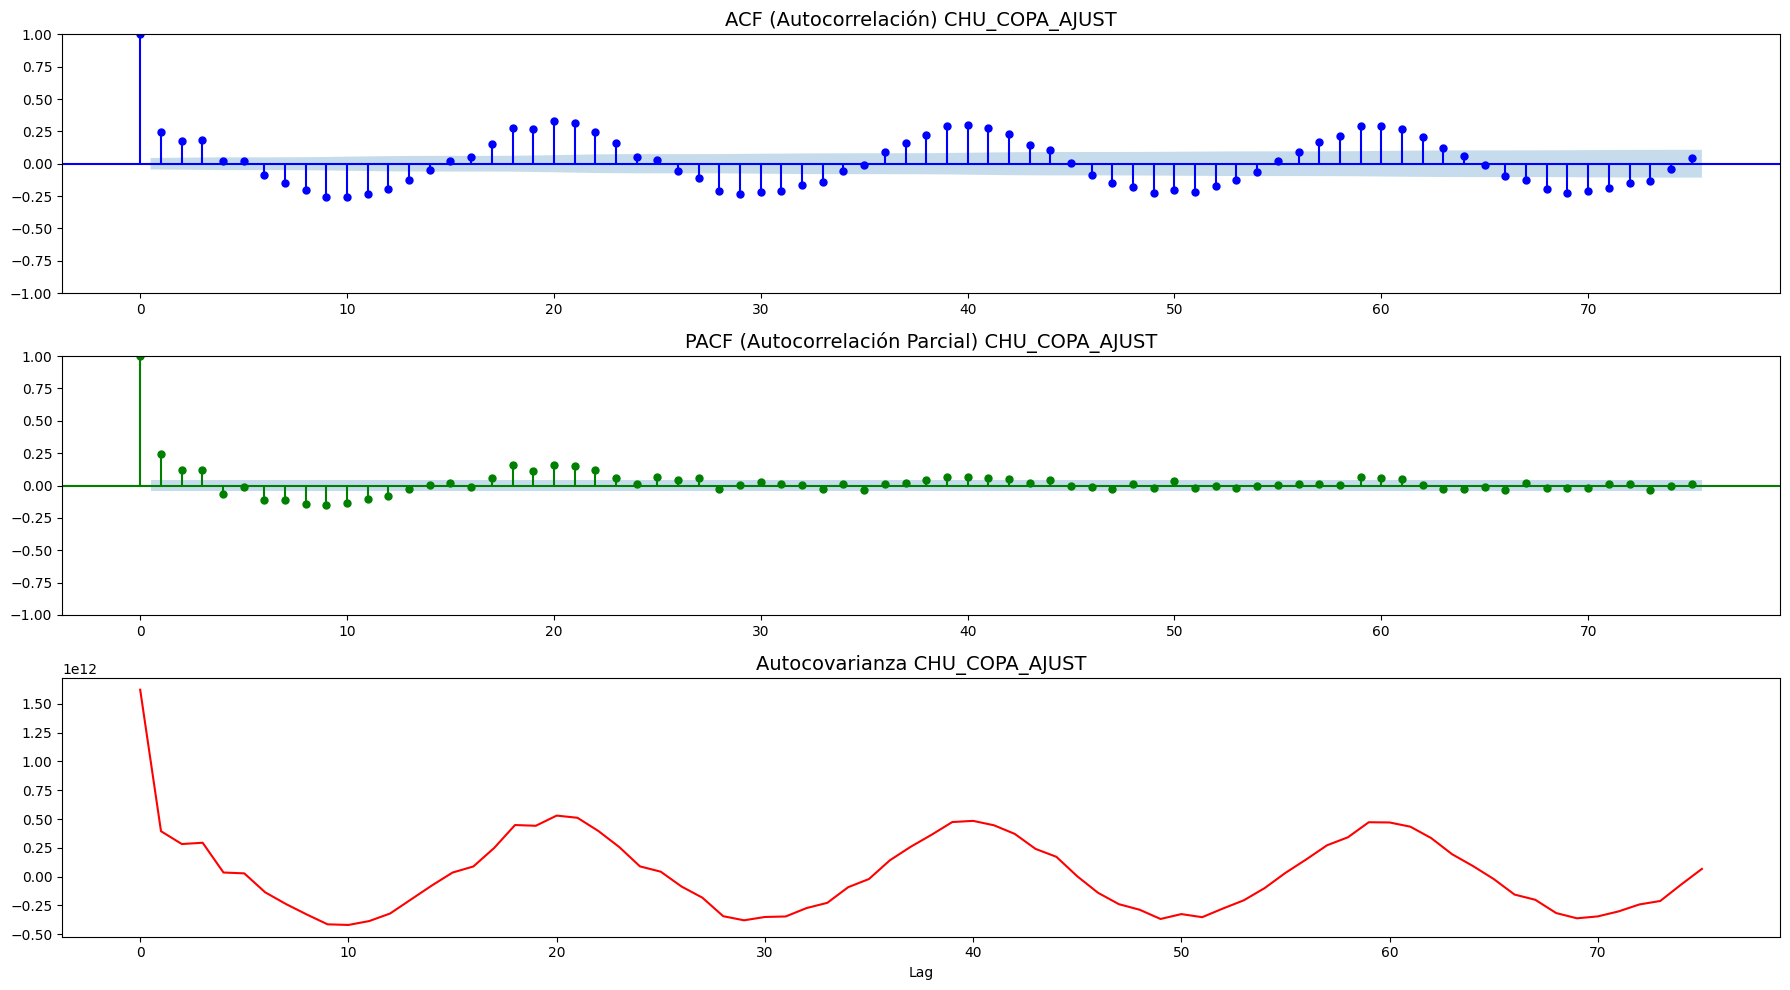

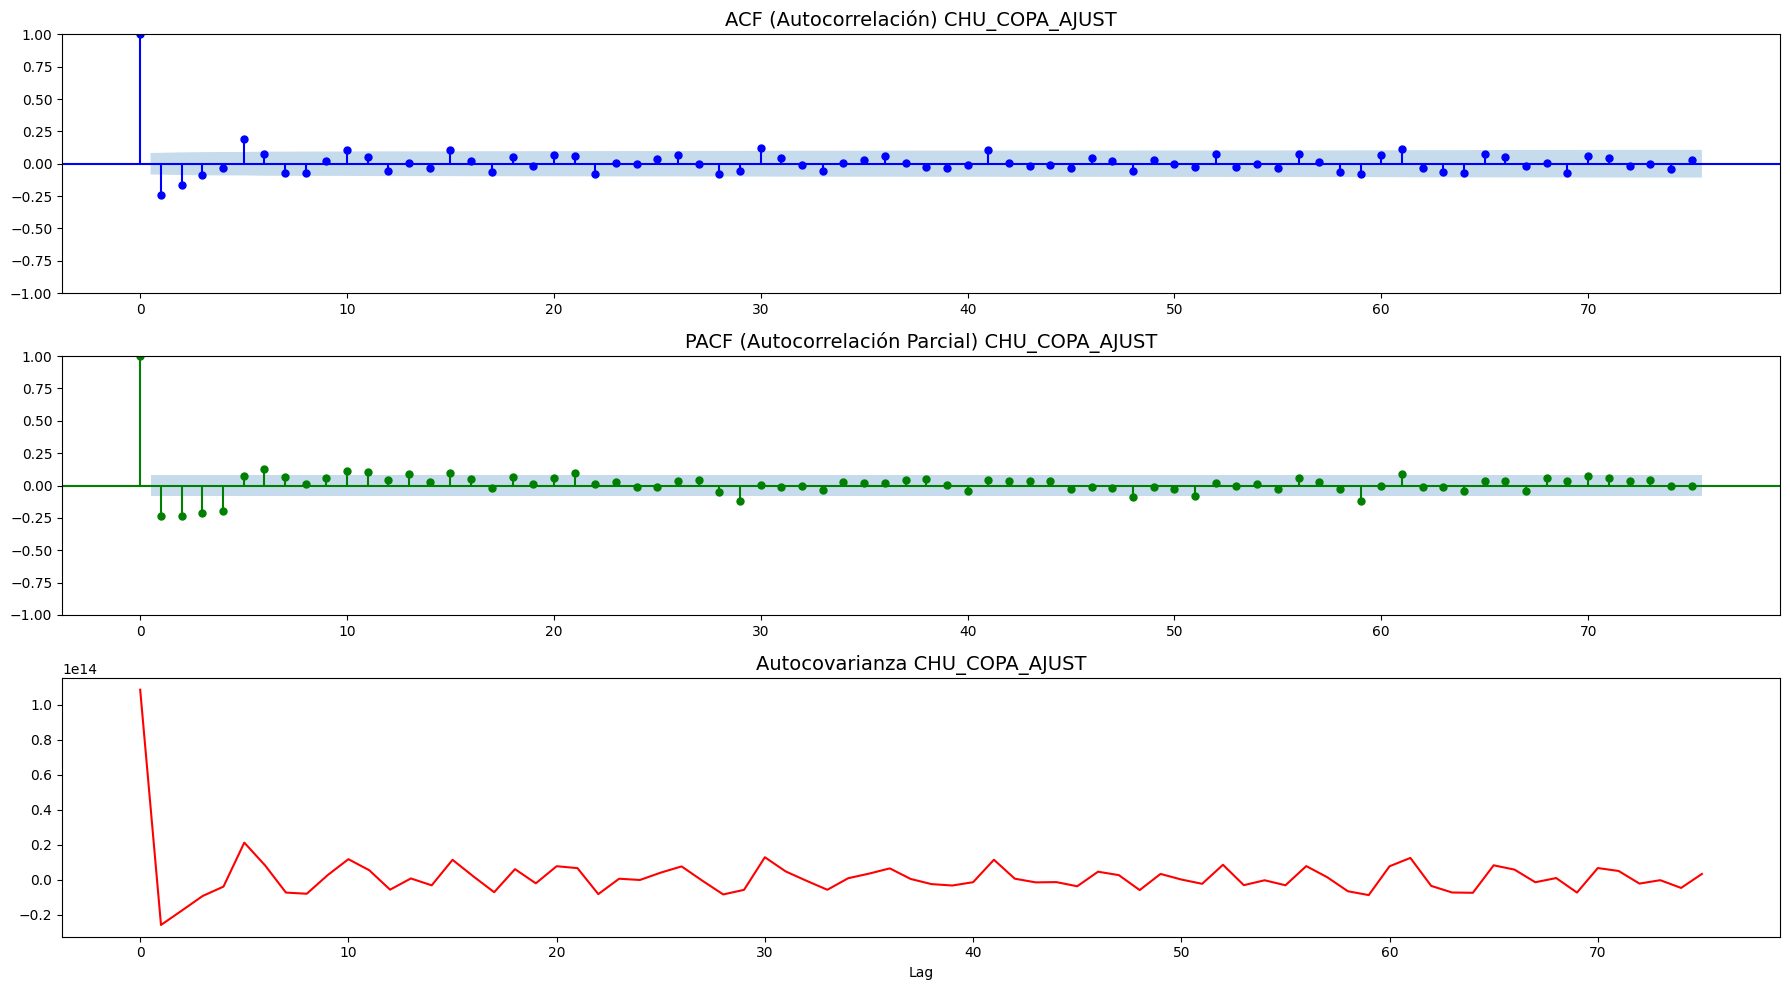

In [30]:
autocov_autocorr(dataframes[0],serie_titulo=dataframes[0].name)
autocov_autocorr(dataframes[1],serie_titulo=dataframes[0].name)
autocov_autocorr(dataframes[2],serie_titulo=dataframes[0].name)

*Vemos que en las tres series no hay estacionalidad porque no vemos picos que se repiten periodicamente. *

## Ejercicio 4
Realizar distintas pruebas de raíces unitarias para determinar si las series elegidas son o no estacionarias.

Test de Dickey Fuller

Estos tests se utilizan para determinar si una serie de tiempo es estacionaria o no.

In [32]:
def test_dickeyfuller(df):
    # ADF para la serie con "none" regression: # No incluye término independiente ni lineal (“None”)
    adf_none_df = adfuller(df, maxlag=None, regression='n', autolag='AIC', store=False, regresults=False)
    print("\nADF Test Results for df (None regression):")
    print('Estadistico ADF: %f' % adf_none_df[0])
    print('p-valor: %f' % adf_none_df[1])
    print('Valores criticos:')
    for key, valor in adf_none_df[4].items():
        print('\t%s: %.3f' % (key, valor))

    # ADF test con Drift: # Incluya término independiente pero no incluye término lineal (“Drift”)
    adf_drift_df = adfuller(df, maxlag=None, regression='c', autolag='AIC', store=False, regresults=False)
    print("\nADF Test Results for df (Drift regression):")
    print('Estadistico ADF: %f' % adf_drift_df[0])
    print('p-valor: %f' % adf_drift_df[1])
    print('Valores criticos:')
    for key, valor in adf_drift_df[4].items():
        print('\t%s: %.3f' % (key, valor))

    # ADF test con Trend: # Incluya ambos términos (“Trend”) - se denomina Ecuación de Dickey Fuller Aumentada
    adf_trend_df = adfuller(df, maxlag=None, regression='ct', autolag='AIC', store=False, regresults=False)
    print("\nADF Test Results for df (Trend regression):")
    print('Estadistico ADF: %f' % adf_trend_df[0])
    print('p-valor: %f' % adf_trend_df[1])
    print('Valores criticos:')
    for key, valor in adf_trend_df[4].items():
        print('\t%s: %.3f' % (key, valor))


In [ ]:
def Augmented_Dickey_Fuller_Test_func(series , column_name):
  print (f'Resultados de la prueba de Dickey-Fuller para columna: {column_name}')
  dftest = adfuller(series, autolag='AIC')
  dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of Observations Used'])
  for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
  print (dfoutput)
  if dftest[1] <= 0.05:
    print("Conclusion:====>")
    print("Rechazar la hipótesis nula")
    print("Los datos son estacionarios.")
  else:
    print("Conclusion:====>")
    print("No rechazar la hipótesis nula")
    print("Los datos no son estacionarios.")

In [36]:
print("CHU_COPA_AJUST")
test_dickeyfuller(dataframes[0])
print("---------------------------------------------------------------------")
print("CHU_REC_PROPIOS_AJUS")
test_dickeyfuller(dataframes[1])
print("---------------------------------------------------------------------")
print("CHU_REGALIAS_AJUST")
test_dickeyfuller(dataframes[2])
print("---------------------------------------------------------------------")

CHU_COPA_AJUST

ADF Test Results for df (None regression):
Estadistico ADF: -0.641313
p-valor: 0.437307
Valores criticos:
	1%: -2.567
	5%: -1.941
	10%: -1.617

ADF Test Results for df (Drift regression):
Estadistico ADF: -5.671137
p-valor: 0.000001
Valores criticos:
	1%: -3.435
	5%: -2.863
	10%: -2.568

ADF Test Results for df (Trend regression):
Estadistico ADF: -6.436652
p-valor: 0.000000
Valores criticos:
	1%: -3.965
	5%: -3.413
	10%: -3.129
---------------------------------------------------------------------
CHU_REC_PROPIOS_AJUS

ADF Test Results for df (None regression):
Estadistico ADF: -0.605548
p-valor: 0.452305
Valores criticos:
	1%: -2.567
	5%: -1.941
	10%: -1.617

ADF Test Results for df (Drift regression):
Estadistico ADF: -4.330791
p-valor: 0.000393
Valores criticos:
	1%: -3.434
	5%: -2.863
	10%: -2.568

ADF Test Results for df (Trend regression):
Estadistico ADF: -4.656140
p-valor: 0.000829
Valores criticos:
	1%: -3.963
	5%: -3.413
	10%: -3.128
--------------------------

Análisis de CHU_COPA_AJUST
Test ADF sin drift ni tendencia:
Estadístico ADF: -0.641313
p-valor: 0.437307
Interpretación: En este caso, el p-valor (0.437307) es mayor que los niveles de significancia comunes (0.01, 0.05, 0.1). Además, el estadístico ADF (-0.641313) es mayor que todos los valores críticos. Esto sugiere que no podemos rechazar la hipótesis nula de no estacionariedad. Es decir, según este test, la serie parece no ser estacionaria.
Test ADF con drift (constante):
Estadístico ADF: -5.671137
p-valor: 0.000001
Interpretación: El p-valor es muy pequeño (0.000001 < 0.01) y el estadístico ADF (-5.671137) es menor que todos los valores críticos. Esto nos permite rechazar la hipótesis nula con un alto nivel de confianza. Según este test, la serie parece ser estacionaria alrededor de una constante.
Test ADF con tendencia:
Estadístico ADF: -6.436652
p-valor: 0.000000
Interpretación: Al igual que en el caso anterior, el p-valor es extremadamente pequeño y el estadístico ADF es menor que todos los valores críticos. Podemos rechazar la hipótesis nula con un alto nivel de confianza. Este test sugiere que la serie es estacionaria alrededor de una tendencia.

Conclusión general:
Los resultados de estos tres tests muestran una imagen interesante:

Sin considerar drift ni tendencia, la serie parece no estacionaria.
Al considerar un término constante (drift), la serie muestra evidencia de estacionariedad.
Al considerar tanto drift como tendencia, la serie muestra una fuerte evidencia de estacionariedad.

Esto sugiere que tu serie temporal probablemente tiene una tendencia y/o un nivel medio distinto de cero. La serie parece ser estacionaria una vez que se tienen en cuenta estos componentes.
Recomendaciones:

Visualiza tu serie temporal para confirmar visualmente la presencia de una tendencia o un nivel medio distinto de cero.
Considera diferenciar la serie si planeas usar modelos que requieran estacionariedad estricta.
Si estás modelando la serie, podrías incluir términos de tendencia y/o constantes en tu modelo para capturar estos componentes.
Ten en cuenta que la elección entre los modelos con drift y con tendencia dependerá de tu conocimiento del proceso que genera los datos y del comportamiento observado en la serie.

A continuacion, analizamos mediante diferentes pruebas el orden de diferenciacion requerido para que la serie pueda llegar a ser estacionaria. Este es un analizis complementario, junto con los otros realizados. 
Las pruebas realizadas son:

* Prueba de Dickey-Fuller aumentada 
* Prueba de Kwiatkowski-Phillips-Schmidt-Shin
* Prueba de Phillips-Perron

In [44]:
def estacionario(y, name):
  print(name)
  # Estimado de número de diferencias con ADF test:Dickey-Fuller
  n_adf = ndiffs(y, test='adf')  # -> 0

  # KPSS test (auto_arima default): Kwiatkowski-Phillips-Schmidt-Shin
  n_kpss = ndiffs(y, test='kpss')  # -> 0

  # PP test: Phillips-Perron
  n_pp = ndiffs(y, test='pp')  # -> 0

  print('Estimado de número de diferencias con ADF test')
  print(n_adf)

  print('Estimado de número de diferencias con KPSS test')
  print(n_kpss)

  print('Estimado de número de diferencias con PP test')
  print(n_pp)

  print('Se debe realizar diferenciación (should_diff) ADF Test')
  adftest = ADFTest(alpha=0.05)
  print(adftest.should_diff(y))
  print("---------------------------------------------------------------------")

In [46]:
estacionario(dataframes[0], dataframes[0].name)
estacionario(dataframes[1], dataframes[1].name)
estacionario(dataframes[2], dataframes[2].name)

CHU_COPA_AJUST
Estimado de número de diferencias con ADF test
0
Estimado de número de diferencias con KPSS test
1
Estimado de número de diferencias con PP test
0
Se debe realizar diferenciación (should_diff) ADF Test
(0.01, False)
---------------------------------------------------------------------
CHU_REC_PROPIOS_AJUST
Estimado de número de diferencias con ADF test
0
Estimado de número de diferencias con KPSS test
1
Estimado de número de diferencias con PP test
0
Se debe realizar diferenciación (should_diff) ADF Test
(0.01, False)
---------------------------------------------------------------------
CHU_REGALIAS_AJUST
Estimado de número de diferencias con ADF test
0
Estimado de número de diferencias con KPSS test
1
Estimado de número de diferencias con PP test
0
Se debe realizar diferenciación (should_diff) ADF Test
(0.01, False)
---------------------------------------------------------------------


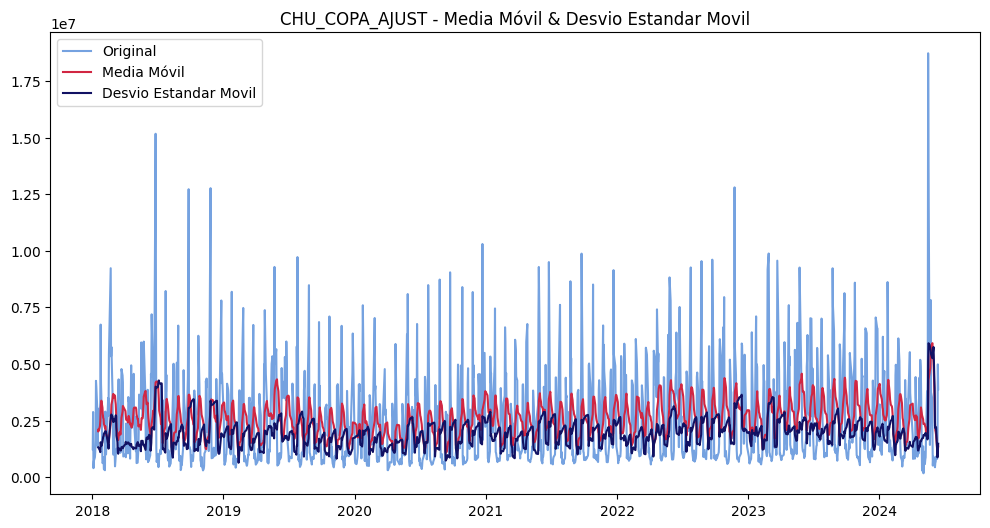

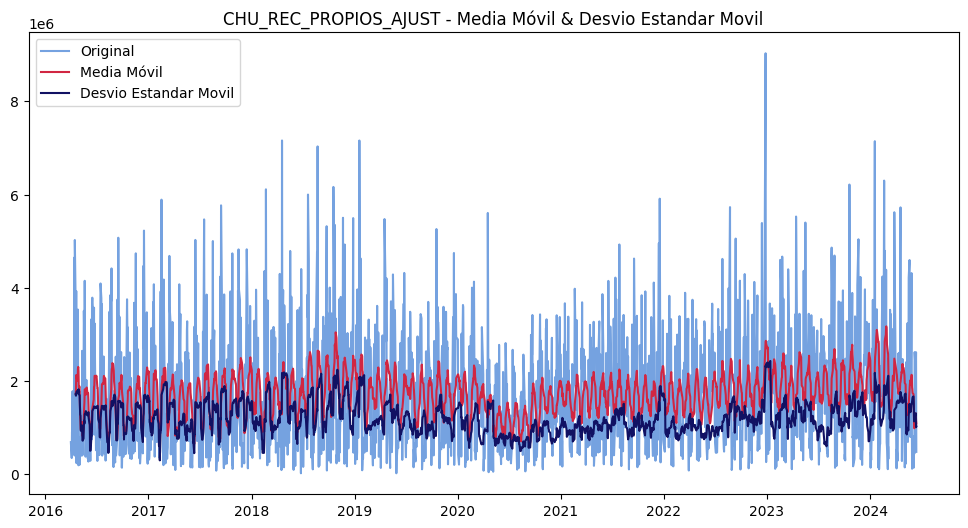

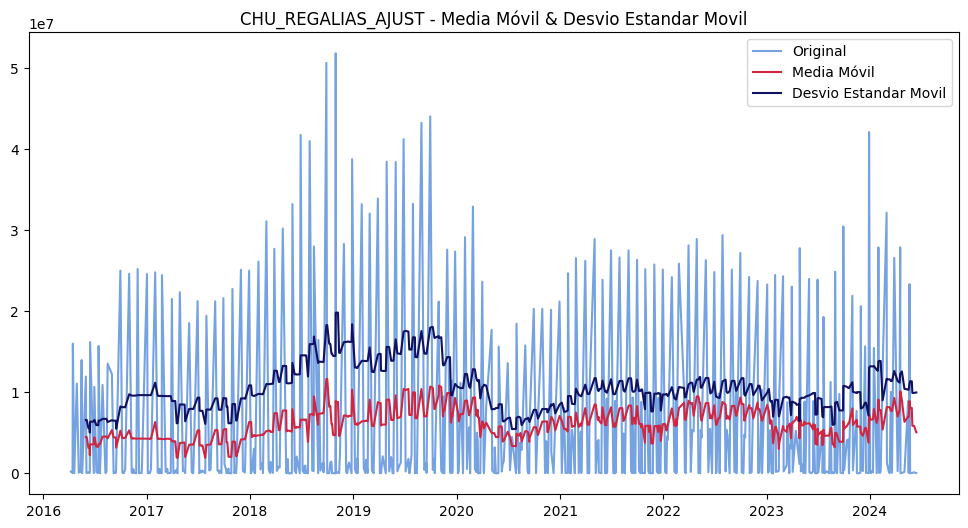

In [57]:
def test_stationarity(timeseries,name):
    # Rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    # Plot rolling statistics:
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(timeseries, color='#75a2e0', label='Original')
    ax.plot(rolmean, color='#d12642', label='Media Móvil')
    ax.plot(rolstd, color='#111163', label='Desvio Estandar Movil')
    ax.legend(loc='best')
    ax.set_title(f'{name} - Media Móvil & Desvio Estandar Movil')

    # Mostrar gráfico en Streamlit
    ax.plot()
test_stationarity(dataframes[0], dataframes[0].name)
test_stationarity(dataframes[1], dataframes[1].name)
test_stationarity(dataframes[2], dataframes[2].name)

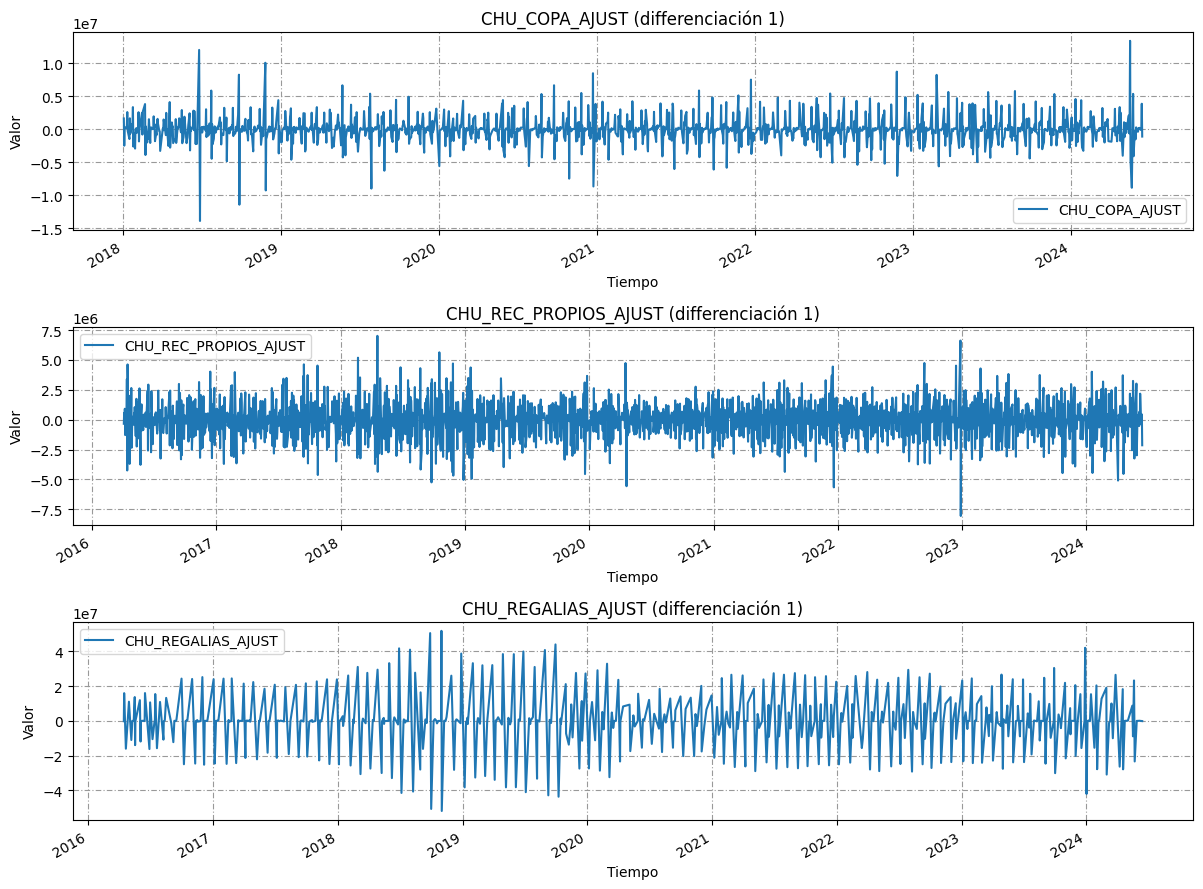

In [60]:
dataframes_diff1 = [df_copa.diff(1).dropna(),
                    df_recprop.diff(1).dropna(),
                    df_regal.diff(1).dropna()]

fig, axes = plt.subplots(3, 1, figsize=(12, 9), dpi=100)  # 3 filas, 1 columna

for i, (df, ax) in enumerate(zip(dataframes_diff1, axes)):
    graficar(serie=df,
             titulo=f"{df.name} (differenciación 1)",
             xlabel="Tiempo",
             ylabel="Valor",
             ax=ax)

plt.tight_layout() 
plt.show()

Volvemos a comprobar estacionariedad

In [61]:
estacionario(dataframes_diff1[0], dataframes_diff1[0].name)
estacionario(dataframes_diff1[1], dataframes_diff1[1].name)
estacionario(dataframes_diff1[2], dataframes_diff1[2].name)

CHU_COPA_AJUST
Estimado de número de diferencias con ADF test
0
Estimado de número de diferencias con KPSS test
0
Estimado de número de diferencias con PP test
0
Se debe realizar diferenciación (should_diff) ADF Test
(0.01, False)
---------------------------------------------------------------------
CHU_REC_PROPIOS_AJUST
Estimado de número de diferencias con ADF test
0
Estimado de número de diferencias con KPSS test
0
Estimado de número de diferencias con PP test
0
Se debe realizar diferenciación (should_diff) ADF Test
(0.01, False)
---------------------------------------------------------------------
CHU_REGALIAS_AJUST
Estimado de número de diferencias con ADF test
0
Estimado de número de diferencias con KPSS test
0
Estimado de número de diferencias con PP test
0
Se debe realizar diferenciación (should_diff) ADF Test
(0.01, False)
---------------------------------------------------------------------


Vemos empíricamente que no es necesario diferenciar más porque las series son estacionarias.

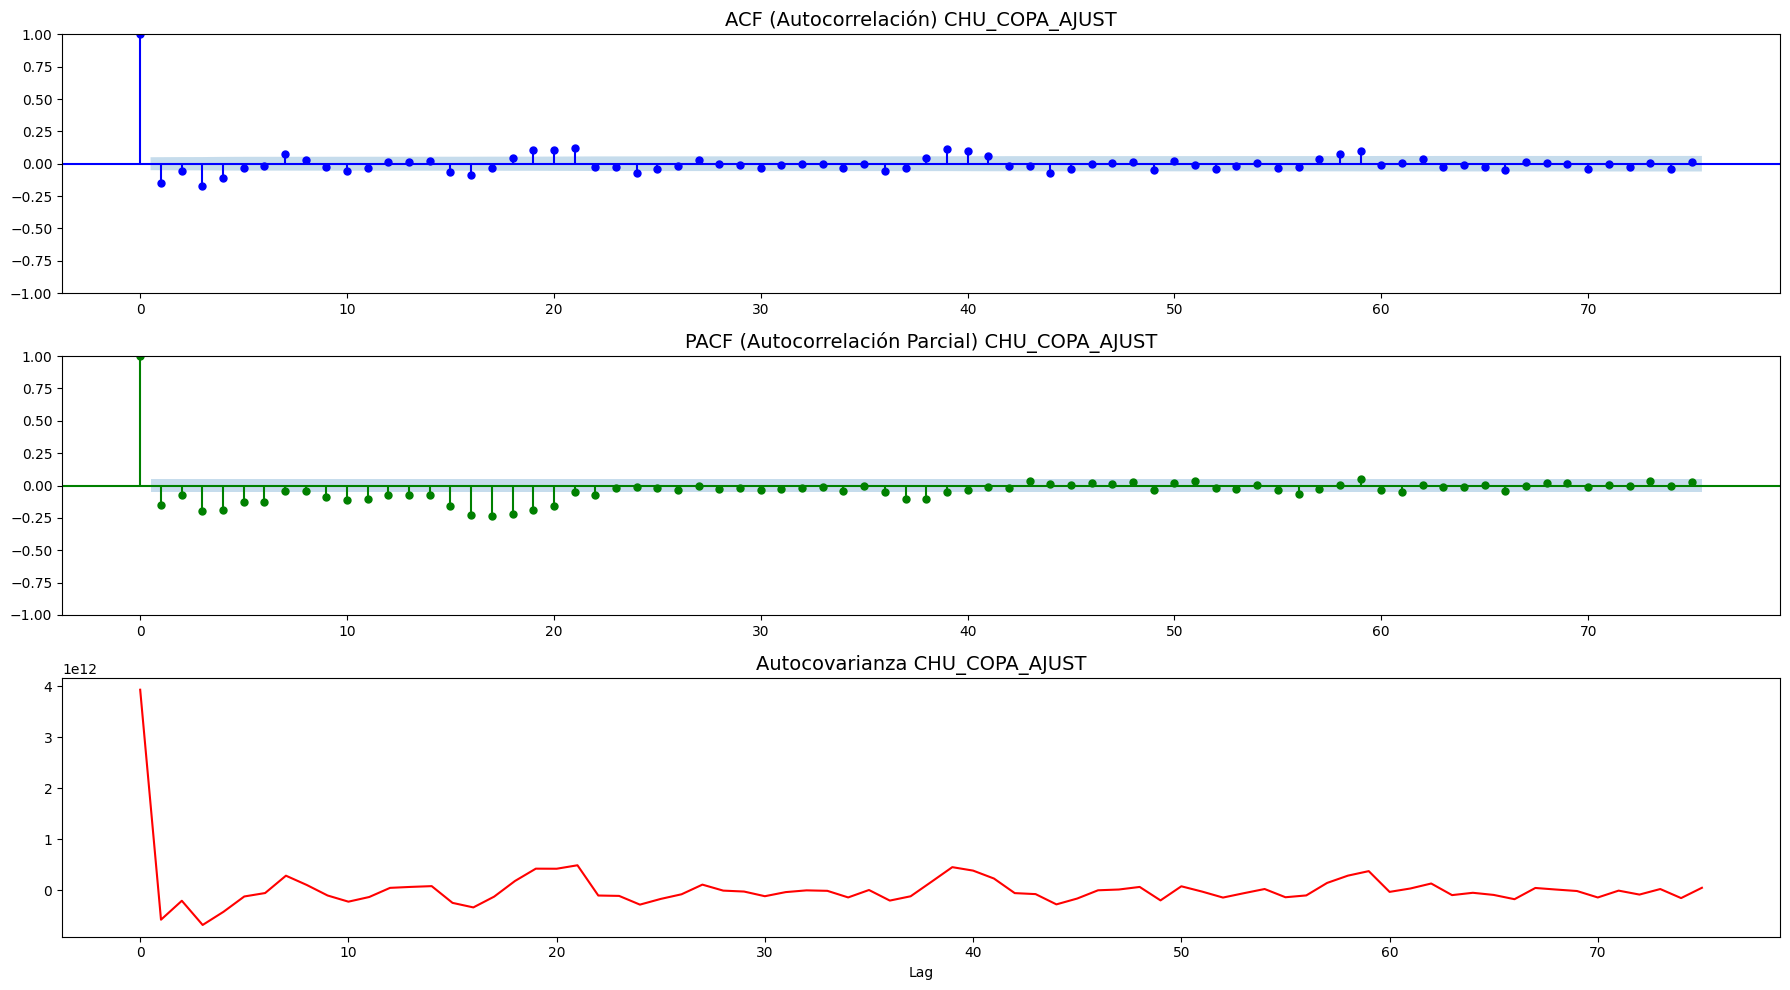

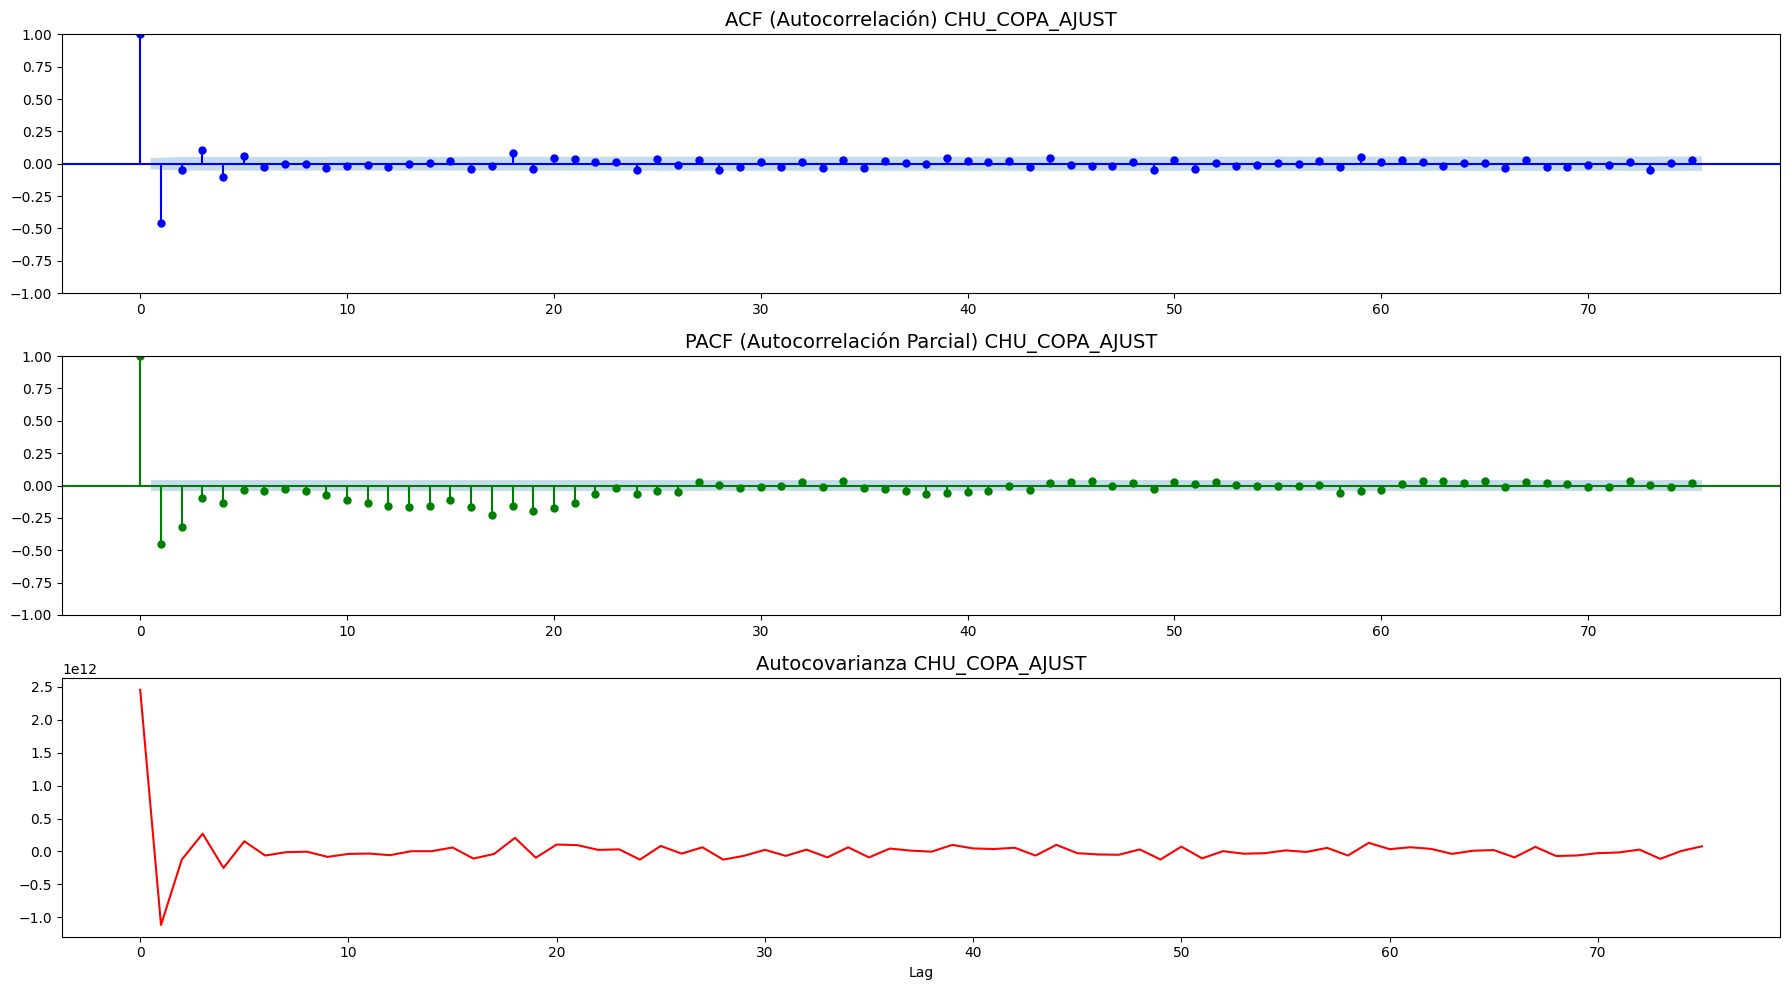

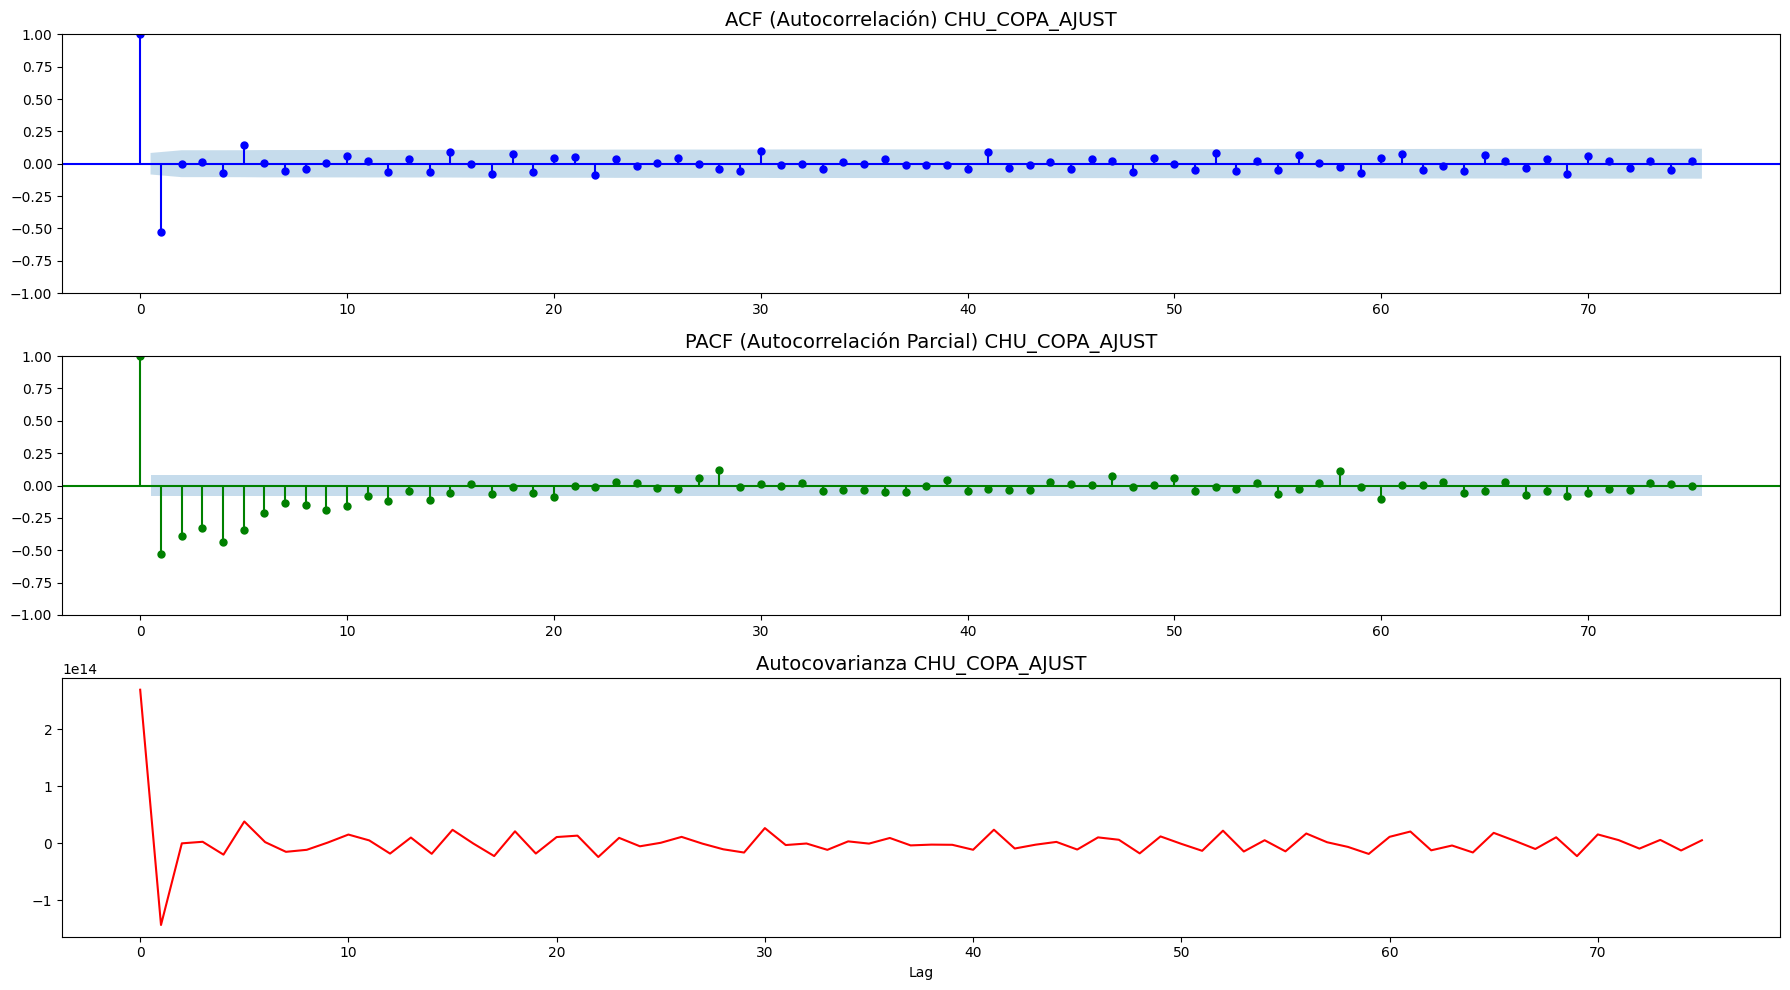

In [64]:
autocov_autocorr(dataframes_diff1[0],serie_titulo=dataframes_diff1[0].name)
autocov_autocorr(dataframes_diff1[1],serie_titulo=dataframes_diff1[0].name)
autocov_autocorr(dataframes_diff1[2],serie_titulo=dataframes_diff1[0].name)

*Vemos una caida exponencial en el ACF por lo que indica estacionariedad. También lo confirmamos con el test de Dickey Fuller.*

<h4>Auto Arima dataset original: CHU_COPA_AJUST</h4>

In [65]:
stepwise_fit = auto_arima(dataframes[0], trace=True,suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=5.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=48429.166, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=48397.674, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=48388.590, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=48427.167, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=48105.704, Time=0.69 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=48090.120, Time=1.49 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=48390.516, Time=0.21 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=48053.122, Time=2.29 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=48330.549, Time=0.60 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=48042.173, Time=7.00 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=48278.576, Time=0.90 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=48039.401, Time=6.30 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=48254.456, Time=1.79 sec
 ARIMA(5,1,2)(0,0,0)[0] i

<h4>AutoArima dataset diferenciado: CHU_COPA_AJUST</h4>

In [66]:
stepwise_fit_diff = auto_arima(dataframes_diff1[0], trace=True,suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=6.21 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=48429.166, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=48397.517, Time=0.19 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=48388.451, Time=0.31 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=48427.167, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=48105.545, Time=0.79 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=48090.050, Time=1.70 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=48390.487, Time=0.32 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=48052.651, Time=2.40 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=48330.536, Time=0.57 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=48041.628, Time=3.91 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=48278.543, Time=1.49 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=48038.824, Time=5.40 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=48254.427, Time=1.10 sec
 ARIMA(5,0,2)(0,0,0)[0] i

<h4>Modelo ARMA dataset original: CHU_COPA_AJUST</h4>

In [68]:
import itertools
import statsmodels.api as sm

p_values = range(0, 8)
q_values = range(0, 8)

def modelo_arma(df):

    resultados = []
    mejor_aic = float("inf")
    mejor_order = None
    mejor_modelo = None


    for p, q in itertools.product(p_values, q_values):
        try:

            modelo = sm.tsa.arima.ARIMA(df, order=(p, 0, q))
            resultado = modelo.fit()

            aic = resultado.aic
            resultados.append((p, q, aic))

            if aic < mejor_aic:
                mejor_aic = aic
                mejor_order = (p, q)
                mejor_modelo = resultado

        except Exception as e:
            print(f"Error en el modelo ARMA({p},{q}): {e}")

    print(f"Mejor modelo ARMA: order={mejor_order} con AIC={mejor_aic}")

    for p, q, aic in resultados:
        print(f"ARMA({p},{q}) AIC: {aic}")

In [70]:
modelo_arma(dataframes[0])

/root/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/root/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/root/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/root/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/roo

### nota
##### COPA ORIGINAL
* El mejor modelo es ARIMA(5,1,1)
* El mejor modelo es ARMA(7,3)

##### COPA DIFERENCIADO
* El mejor modelo es ARIMA(5,0,1)


<h4>Modelo ARMA dataset diff: CHU_COPA_AJUST</h4>

In [69]:
modelo_arma(dataframes_diff1[0])

/root/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/root/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/root/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/root/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/roo

KeyboardInterrupt: 

<h4> Métricas para modelos de autoarima automatico y manual </h4>

Modelo 1

In [ ]:
modelo_ARMA_1 = sm.tsa.arima.ARIMA(train, order=(1,0,1))
resultado_ARMA_1 = modelo_ARMA_1.fit()
resultado_ARMA_1.summary()

Modelo 2

In [ ]:
modelo_ARMA_2 = sm.tsa.arima.ARIMA(train, order=(1,0,1))
resultado_ARMA_1 = modelo_ARMA_2.fit()
resultado_ARMA_1.summary()

## Ejercicio 5

Efectuar una estimación de la serie temporal con distintos órdenes de parámetros de modelos SARIMA y encontrar aquel que se ajuste mejor a los datos (pueden emplear Criterios de Información/Selección y analizar significatividad individual y global de los parámetros del modelo).

## Ejercicio 6

Evaluar alguna métrica de performance teniendo en cuenta el entrenamiento del modelo entre Training Set y Testing Set.

## Ejercicio 7

Detallar una comparación con otros modelos estimados.


## Ejercicio 8

Efectuar un Análisis de Diagnóstico de las series temporales (Análisis sobre los Residuos del modelo, análisis gráfico de FAC, test de Ljung-Box, etc.).

## Ejercicio 9

Pronosticar con el modelo seleccionado para cada serie para una ventana temporal razonable, en función de la periodicidad y el comportamiento de las mismas.

##  Ejercicio 10
Construir un modelo de Vectores Autorregresivos (VAR) con las series elegidas para realizar predicciones sobre cada una de ellas.


## Ejercicio 11
Analizar la función impulso respuesta y realizar distintas pruebas para analizar la causalidad.

Justificar la elección del modelo con todo lo visto en clase. Es posible complementar con otros análisis

## Ejercicio 12

En caso de presentar estacionalidad alguna de las series elegidas, se solicita determinar la representación más adecuada mediante algún modelo SARIMA y comparar los resultados con los modelos determinados en el trabajo anterior.

(Opcional) Realizar la prueba de hipótesis de HEGY para testear la conjetura de raíz unitaria sobre las series elegidas.


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=9292b23b-d668-48da-87b9-72d6854ea93f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>